In [1]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
# from pattern.es import lemma
from nltk.stem import WordNetLemmatizer

# from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(15,15))
# :rc:`figure.figsize` = ``[6.4, 4.8]``.
plt.rcParams['figure.figsize']=(15,5)


import joblib
from tqdm import tqdm, tqdm_notebook

from statistics import mean
import re
# nltk.download('punkt')
import unicodedata
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from spellchecker import SpellChecker
import emoji
import textstat
from wordcloud import WordCloud

from sklearn.metrics import classification_report

In [2]:
psy=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube01-Psy.csv")
kp=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube02-KatyPerry.csv")
lmfao=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube03-LMFAO.csv")
eminem=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube04-Eminem.csv")
shakira=pd.read_csv("Data/YouTubeSpamCollection_FromUCI/Youtube05-Shakira.csv")

data=pd.concat([psy,kp,lmfao,eminem,shakira],axis=0,ignore_index=True)
data.to_csv('JoinedTrainingData.csv')
print('This is training data\'s shape :',data.shape)

This is training data's shape : (1956, 5)


###  Feature Engineering: 


Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

#### Length of comments

In [3]:
data['CommentLength']=data['CONTENT'].apply(len)
data.head(2)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166


In [4]:
# sns.boxplot(y=data['CommentLength'],x=data['CLASS'],data=data,fliersize =1);

In [5]:
# filt=data['CommentLength']>1000
# data.loc[filt,'CONTENT']

In [6]:
# data.iloc[1407,3]

Can do >200 as 1 else 0?

####  % of UpperCase letters

In [7]:
# Function to count capital letters
def countCaps(comment):
    count=0
    for c in comment:
        if c.isupper():
            count+=1
    return round(count*100/len(comment),2)
        
        

data['%OfUpperCaseLetters']=data['CONTENT'].apply(countCaps)
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05


####  Find no. of URLs in comments

In [8]:
pattern='(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'

data['NoOfURL']=data['CONTENT'].apply(lambda x: len(re.findall(pattern,x)))

####  Avg length of each word

In [9]:
def AvgLengthOfEachWord(comment):
    return(round(mean([len(c) for c in comment.split(' ')]),2))

data['AvgLengthOfEachWord']=data['CONTENT'].apply(AvgLengthOfEachWord)

#### No. of stop words in each comment

In [10]:
def NoOfStopWords(comment):
    count=0
    for word in comment:
        if word in stopwords.words('english'):
            count+=1
    return count

data['NoOfStopWords']=data['CONTENT'].apply(NoOfStopWords)

####  No. of sentences in each review

In [11]:
def NoOfSentences(comment):
    return(len(sent_tokenize(comment)))

data['NoOfSentences']=data['CONTENT'].apply(NoOfSentences)

#### No. of words in each review

In [12]:
def NoOfWords(comment):
    return(len(word_tokenize(comment)))

data['NoOfWords']=data['CONTENT'].apply(NoOfWords)

####  No. of unique words

In [13]:
def NoOfUniqueWords(comment):
    
    return(len(set(word_tokenize(comment))))

data['NoOfUniqueWords']=data['CONTENT'].apply(NoOfUniqueWords)

In [14]:
data.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS', 'CommentLength',
       '%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       'NoOfStopWords', 'NoOfSentences', 'NoOfWords', 'NoOfUniqueWords'],
      dtype='object')

In [15]:
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,NoOfSentences,NoOfWords,NoOfUniqueWords
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,1,13,13
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,3,40,31


####  Add features for readability, complexity and grade level (using Textstat library)

In [16]:
data['FleschReadingEase']=data['CONTENT'].apply(lambda x: textstat.flesch_reading_ease(x))

data['GunningFog']=data['CONTENT'].apply(lambda x: textstat.gunning_fog(x))

data['SmogIndex']=data['CONTENT'].apply(lambda x: textstat.smog_index(x))

data['ARI']=data['CONTENT'].apply(lambda x: textstat.automated_readability_index(x))

data['ColemanLiauIndex']=data['CONTENT'].apply(lambda x: textstat.coleman_liau_index(x))

data['TextStandard']=data['CONTENT'].apply(lambda x: textstat.text_standard(x,float_output=True))

data['AvgSentenceLength']=data['CONTENT'].apply(lambda x: textstat.avg_sentence_length(x))

data.head(2)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,NoOfSentences,NoOfWords,NoOfUniqueWords,FleschReadingEase,GunningFog,SmogIndex,ARI,ColemanLiauIndex,TextStandard,AvgSentenceLength
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,1,13,13,88.74,3.2,0.0,11.4,13.01,3.0,8.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,3,40,31,81.63,6.0,0.0,7.3,6.49,6.0,15.0


### Clean-up comments

In [17]:
# lemmatize as per part of speech of the word
# It may not be possible manually provide the corrent POS tag for every word for large texts.
# So, instead, we will find out the correct POS tag for each word, map it to the right input character
# that the WordnetLemmatizer accepts and pass it as the second argument to lemmatize().

def lemmatize(cleanTextList):
    
#     Create a dictionary to map POS
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
#     tag part of speech for each word
    pos_tagged_text = nltk.pos_tag(cleanTextList)
    lemmatizer=WordNetLemmatizer()
    
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [18]:
def correct_spellings(wordList):
    spell = SpellChecker()
    corrected_text = []
    
    # find those words that may be misspelled
    misspelled = spell.unknown(wordList.split())
    
    for word in wordList.split():
        if word in misspelled:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)


In [19]:
correct_spellings('I lve gameens')

'I love games'

List of cleaning items:
- Remove URLs
- Remove html tags
- Remove Emojis
- Convert to lower case
- Remove non-english characters
- Remove stop-words
- Remove punctuations 
- Replace ascent characters
- Lemmatize words
- Correct spelling mistakes


In [20]:
def cleanComment(comment):
    try:
    #   Remove URLS
        pattern1='(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
        comment=re.sub(pattern1,' ',comment)
        
    #   Remove html tags
        comment=re.sub('<[^<]+?>', '', comment)
        
    #   Remove \ufeff    
        comment=comment.replace(u'\ufeff', '')
        
    #   Remove Emojis
        comment=emoji.get_emoji_regexp().sub(r'', comment)
        
    #   turn to lowercase
        comment=comment.lower()
        
    #   Replace digits with 999
        comment=re.sub(r'\d+','999',comment)
        
    #   Remove non-english words
    #   Reference:https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
        comment = re.sub("([^\x00-\x7F])+"," ",comment)

    #   Tokenize to words
        wordList=word_tokenize(comment)
#         print(wordList)

    #   Remove english stopwords
        wordList=[word for word in wordList if word not in stopwords.words('english')]

    #   Remove punctuations
        wordList=[word for word in wordList if word not in string.punctuation]
#         print(wordList)

    #   Convert ascent characters to their normal english characters
    #   Reference: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
        cleanedTextList=[unicodedata.normalize('NFKD',word).encode('ascii', 'ignore').decode('utf-8', 'ignore') \
                  for word in wordList]
#         print(cleanedTextList)
        
    #   Lemmatize
        lemmatizedText=lemmatize(cleanedTextList)
#         print(lemmatizedText)

    #   Spell Correction
#         correctedText=correct_spellings(lemmatizedText)
#         print(correctedText)

        return lemmatizedText
    except:
        print(comment)
            

In [21]:
tqdm_notebook().pandas()
data['CleanWordList']=data['CONTENT'].progress_apply(lambda x: cleanComment(x));

In [27]:
# Drop rows with no comment 
data.dropna(subset=['CleanWordList'],inplace=True)
data.shape

(1903, 21)

In [28]:
data.to_csv('Data/cleanedData.csv',index=False)

In [29]:
data=pd.read_csv('Data/cleanedData.csv')
data.head(2)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CommentLength,%OfUpperCaseLetters,NoOfURL,AvgLengthOfEachWord,NoOfStopWords,...,NoOfWords,NoOfUniqueWords,FleschReadingEase,GunningFog,SmogIndex,ARI,ColemanLiauIndex,TextStandard,AvgSentenceLength,CleanWordList
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,1.79,0,6.12,18,...,13,13,88.74,3.2,0.0,11.4,13.01,3.0,8.0,huh anyway check tube channel kobyoshi999
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166,12.05,0,4.22,44,...,40,31,81.63,6.0,0.0,7.3,6.49,6.0,15.0,hey guy check new channel first vid u monkey '...


#### Text classification


In [30]:
X=data['CleanWordList']
y=data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25 ,random_state=147)

countVectorizer=CountVectorizer(min_df=5)

# Create document term matrix for training and testing data
X_train_dtm = countVectorizer.fit_transform(X_train)
X_test_dtm  = countVectorizer.transform(X_test)

#Initialize clasifier
clf=MultinomialNB()

# Initialize Kflod for cross validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Calculate accuracy of training data
scores_trainingData = cross_val_score(clf, X_train_dtm.toarray(),y_train, cv=cv)
print('Training - cross val score:',scores_trainingData.mean())

# Train and predict
clf.fit(X_train_dtm.toarray(),y_train)
prediction=clf.predict(X_test_dtm.toarray())

# Calculate accuracy of class predictions
scores_testingData = cross_val_score(clf, X_test_dtm.toarray(),prediction, cv=cv)
print('Testing - cross val score:',scores_testingData.mean())

Training - cross val score: 0.8878714268187953
Testing - cross val score: 0.9223245614035088


####  Confusion matrix

In [31]:
labels=np.unique(y_test)
labels

array([0, 1], dtype=int64)

In [32]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       243
           1       0.88      0.89      0.89       233

    accuracy                           0.89       476
   macro avg       0.89      0.89      0.89       476
weighted avg       0.89      0.89      0.89       476



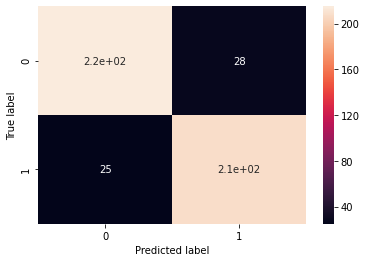

In [33]:
# print the confusion matrix
confusion_matrix=metrics.confusion_matrix(y_test, prediction,labels=labels)


sns.heatmap(confusion_matrix,annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label');

The model is working good for categorizing Hams(0) but struggling to categorize spams(1).


####  Word Cloud 

In [34]:
#Reference: https://github.com/justmarkham/pycon-2016-tutorial/blob/master/tutorial_with_output.ipynb

tokenList=countVectorizer.get_feature_names()
tokenList[:10]

['999',
 '999k',
 '999th',
 'absolutely',
 'act',
 'actually',
 'adam',
 'advertise',
 'advertisement',
 'africa']

In [35]:
hamFeatureCount=clf.feature_count_[0,:].astype(int)
spamFeatureCount=clf.feature_count_[1,:].astype(int)

hamFeatureCount

array([263,   1,   2,   3,   2,   3,   0,   0,   0,   5,   7,   1,   7,
         1,   3,   2,   5,   4,   3,   1,   4,   0,   2,   4,   1,   1,
         1,  22,   4,   8,   9,   0,   4,  16,   1,   5,  43,   3,   4,
        34,   3,   2,   3,   4,   1,   1,   0,   0,   0,   0,   1,   5,
        11,   1,   3,   3,   0,   0,  16,  13,   0,  17,   7,   3,   0,
         7,   6,   4,   0,   4,  15,   8,   1,   8,   3,   0,   7,   0,
         1,   1,   0,   6,   0,   5,   1,  24,   6,   1,   3,  12,  21,
        10,   3,   5,   3,   0,   0,   0,   2,   6,   2,   6,   0,   5,
         1,   3,   7,   0,   1,   1,   0,  11,   1,   2,  14,  11,   0,
        13,  35,  11,   2,  14,   1,   9,   4,  34,   0,  11,   2,  12,
         4,   3,   5,   1,   8,  11,   2,   4,   1,   2,   4,   2,   1,
         6,   3,   0,   1,   4,   2,   0,   8,   3,   0,   0,   1,   0,
         3,   0,  48,   4,   4,   0,  14,   0,   2,   0,   3,   1,   4,
         0,   5,   9,   4,  76,   0,  10,   5,   4,   0,   5,  1

In [36]:
columns={'TokenName':tokenList,
         'No. of occurances in Ham':hamFeatureCount,
         'No. of occurances in Spam':spamFeatureCount,
         '% of total in Ham':hamFeatureCount/clf.class_count_[0],
         '% of total in Spam':hamFeatureCount/clf.class_count_[1]}

tokenDf=pd.DataFrame(columns).set_index('TokenName')
tokenDf.sample(5)

,No. of occurances in Ham,No. of occurances in Spam,% of total in Ham,% of total in Spam
TokenName,,,,
adam,0,5,0.000000,0.000000
comment,13,70,0.018625,0.017833
rock,16,0,0.022923,0.021948
online,0,33,0.000000,0.000000
official,6,0,0.008596,0.008230


##### Most frequent words in Ham comments

In [37]:
# Most frequent words in Ham comments
frequentHamWords=tokenDf['No. of occurances in Ham'].sort_values(ascending=False)
frequentHamWords[:10]


TokenName
999        263
song       175
love       114
like        76
view        69
video       63
katy        48
best        43
shakira     38
get         35
Name: No. of occurances in Ham, dtype: int32

In [38]:
# Most frequent words in Spam comments
frequentSpamWords=tokenDf['No. of occurances in Spam'].sort_values(ascending=False)
frequentSpamWords[:10]

TokenName
999          497
check        429
video        212
please       180
subscribe    179
youtube      168
channel      150
like         121
make         111
com          106
Name: No. of occurances in Spam, dtype: int32

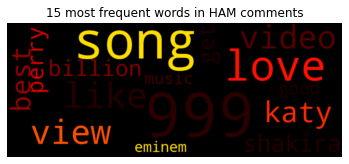

In [39]:
wc=WordCloud(width=1000,height=400,colormap='hot').generate_from_frequencies(frequencies=dict(frequentHamWords[:15]))
plt.imshow(wc, interpolation="bilinear")
plt.title("15 most frequent words in HAM comments")
plt.axis("off");

##### Most frequent words in Spam comments

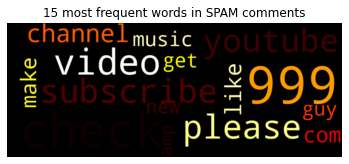

In [40]:
wc=WordCloud(width=1000,height=400,colormap='hot').generate_from_frequencies(frequencies=dict(frequentSpamWords[:15]))
plt.imshow(wc, interpolation="bilinear")
plt.title("15 most frequent words in SPAM comments")
plt.axis("off");

##### Sample words in overlapping categorization

In [41]:
filt=abs(tokenDf['No. of occurances in Ham']-tokenDf['No. of occurances in Spam'])<=5
overlappingWords=tokenDf[filt].reset_index()
overlappingWords=overlappingWords['TokenName'].sample(15,random_state=123)
overlappingWords

116     reach
81      least
132      step
24     button
100      much
95     minute
42         em
41       else
141        uk
74        job
65       hate
8       agree
59        god
146     whole
63     happen
Name: TokenName, dtype: object

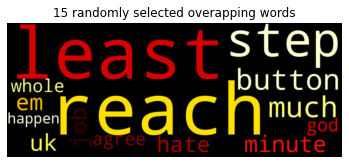

In [42]:
x=' '.join(overlappingWords[:15].to_list())

wc=WordCloud(width=1000,height=400,colormap='hot').generate(x)
plt.imshow(wc, interpolation="bilinear")
plt.title("15 randomly selected overapping words")
plt.axis("off");


#### Grid search multiple models

##### Logistic regression

In [43]:
clf_lr=LogisticRegression()
clf_lr.fit(X_train_dtm.toarray(),y_train)

print('Training score for Logistic Regression: ',clf_lr.score(X_train_dtm.toarray(),y_train))

print('Test score for Logistic Regression: ',clf_lr.score(X_test_dtm.toarray(),y_test))

C:\Users\Preeti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score for Logistic Regression:  0.9411352487736511
Test score for Logistic Regression:  0.9159663865546218


##### Random Forest Classifier

In [44]:
clf_rfc = RandomForestClassifier()

param_grid_rfc={'n_jobs':[-1],
            'n_estimators':list(np.arange(3,15,3)), #3,15,2
            'max_depth':list(np.arange(2,5))
           }

gc_rfc=GridSearchCV(clf_rfc,param_grid=param_grid_rfc,cv=cv)

gc_rfc.fit(X_train_dtm.toarray(),y_train)

print('Training score for Random Forest Classifier: ',gc_rfc.score(X_train_dtm.toarray(),y_train))

print('Test score for Random Forest Classifier: ',gc_rfc.score(X_test_dtm.toarray(),y_test))

Training score for Random Forest Classifier:  0.8521373510861948
Test score for Random Forest Classifier:  0.865546218487395


##### Xgboost Classifier

In [45]:
clf_xgb = XGBClassifier()

param_grid_xgb={'n_jobs':[-1],
            'n_estimators':[10,20,30,50], 
            'max_depth':list(np.arange(3,30,5))
           }

gc_xgb=GridSearchCV(clf_xgb,param_grid=param_grid_xgb,cv=cv)

gc_xgb.fit(X_train_dtm.toarray(),y_train)

print('Training score for XGB Classifier: ',gc_xgb.score(X_train_dtm.toarray(),y_train))

print('Test score for  XGB Classifier: ',gc_xgb.score(X_test_dtm.toarray(),y_test))

Training score for XGB Classifier:  0.948843728100911
Test score for  XGB Classifier:  0.9222689075630253


##### Model Comparision

In [46]:
modelScores={'Model Name':['Logistic Regression',
                       'Random Forest Classifier',
                       'XGBoost Classifier'],
         'Training Score':[clf_lr.score(X_train_dtm.toarray(),y_train),
                          gc_rfc.score(X_train_dtm.toarray(),y_train),
                          gc_xgb.score(X_train_dtm.toarray(),y_train)] ,
         'Testing Score': [clf_lr.score(X_test_dtm.toarray(),y_test),
                          gc_rfc.score(X_test_dtm.toarray(),y_test),
                          gc_xgb.score(X_test_dtm.toarray(),y_test)]}

modelScoresDf=pd.DataFrame(data=modelScores)

modelScoresDf.style.highlight_max(axis=0)

,Model Name,Training Score,Testing Score
0,Logistic Regression,0.941135,0.915966
1,Random Forest Classifier,0.852137,0.865546
2,XGBoost Classifier,0.948844,0.922269


In [47]:
prediction_xgb=gc_xgb.predict(X_test_dtm.toarray())

In [48]:
print(classification_report(y_test,prediction_xgb))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       243
           1       0.95      0.89      0.92       233

    accuracy                           0.92       476
   macro avg       0.92      0.92      0.92       476
weighted avg       0.92      0.92      0.92       476

